# *RECONSTRUCTION VALIDATION*

The Analog Method (AM) is a statistical downscaling method very well suited for reconstruction of climatic time series. The reconstruction can reproduce the climatic characteristics of the local phenomena a certain region, based on the relationship between the large scale and the observed local weather patterns.

To validate the quality of the reconstructions is the important to look how the climatic characteristics are reproduced.

In [43]:
import os
import cfgrib
import datetime
import itertools
import rascal.utils
import rascal.analogs
import rascal.skill_evaluation

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy.stats import percentileofscore


In [2]:
observations_directory = "./data/observations/"
reanalysis_directory = "/home/alvaro/data/NWP/era20c/"
reconstructions_directory = "./output/PCNR/SURF_71.162andSURF_72.162-SURF_71.162andSURF_72.162-1"

In [36]:
initial_year = 1900
final_year = 2010

station_to_validate = "segovia"
variable_to_validate = "PCNR"

groupings = {
    "TMEAN": "mean",
    "TMAX": "mean",
    "TMIN": "mean",
    "PCNR": "hydrosum"
}

reanalysis_variables = {
    "TMEAN": ["SURF_167"],
    "TMAX": ["SURF_167"],
    "TMIN": ["SURF_167"],
    "PCNR": ["SURF_228"]
}

reanalysis_grouping = {
    "TMEAN": "1D_mean",
    "TMAX": "1D_max",
    "TMIN": "1D_min",
    "PCNR": "1D_sum"
}

units = {
    "TMEAN": "[$^\circ$C]",
    "TMAX": "[$^\circ$C]",
    "TMIN": "[$^\circ$C]",
    "PCNR": "[mm]"
}

### STATION DATA

In [4]:
station = rascal.utils.Station(path= observations_directory + station_to_validate + '/')
station_data = station.get_data(variable=variable_to_validate)
station_data.index.name = "time"

### REANALYSIS DATA

In [5]:
# Years of the reanalysis data
years = [str(y) for y in range(initial_year, final_year + 1)]

# The precipitation is a forecast variable in ERA20C, select only one ensemble member
if variable_to_validate == 'PCNR':
    ensemble_member = 0
else:
    ensemble_member = None

# Get the file paths of the reanalysis variable
secondary_predictor_files = rascal.utils.get_files(
    nwp_path=reanalysis_directory,
    variables=reanalysis_variables[variable_to_validate],
    dates=years,
    file_format=".grib"
)

# Get the variable as a time series in the gridpoint of the station
reanalysis = rascal.analogs.Predictor(
    paths=secondary_predictor_files,
    grouping=reanalysis_grouping[variable_to_validate],
    lat_min=station.latitude,
    lat_max=station.latitude,
    lon_min=station.longitude,
    lon_max=station.longitude,
    mosaic=False,
    number=ensemble_member
)
reanalysis_data = reanalysis.data.drop_vars(["latitude", "longitude"]).to_dataframe()
                
# Change variable name to RASCAL common acronym
reanalysis_data.columns = [variable_to_validate]

# Change units
# Kelvin to Celsius
if variable_to_validate in ["TMAX", "TMIN", "TMEAN", "TMPA"]:
    reanalysis_data = reanalysis_data-273.1
# m to mm
elif variable_to_validate == "PCNR":
    reanalysis_data = reanalysis_data*1000

Function 'get_files' executed in 0.0379s
Function 'open_data' executed in 207.0329s


In [6]:
reanalysis_data

,PCNR
time,
1900-01-01,1.495600
1900-01-02,0.750542
1900-01-03,4.252434
1900-01-04,7.770300
1900-01-05,5.262375
...,...
2010-12-27,0.004172
2010-12-28,0.012875
2010-12-29,0.005126


### Daily Series

In [7]:
reconstructions_daily = rascal.skill_evaluation.get_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1D',
    grouping=groupings[variable_to_validate]
)

if groupings[variable_to_validate] == "mean":
    station_data_daily = station_data.resample('1D').mean()
    reanalysis_data_daily = reanalysis_data.resample('1D').mean()
elif groupings[variable_to_validate] == "sum" or groupings[variable_to_validate] == "hydrosum" :
    reanalysis_data_daily = reanalysis_data.resample('1D').sum()
    station_data_daily = station_data.resample('1D').sum()
 

In [8]:
station_data_daily

,PCNR
time,
1948-01-01,0.0
1948-01-02,0.0
1948-01-03,0.0
1948-01-04,0.0
1948-01-05,0.0
...,...
2023-07-27,0.2
2023-07-28,0.0
2023-07-29,0.0


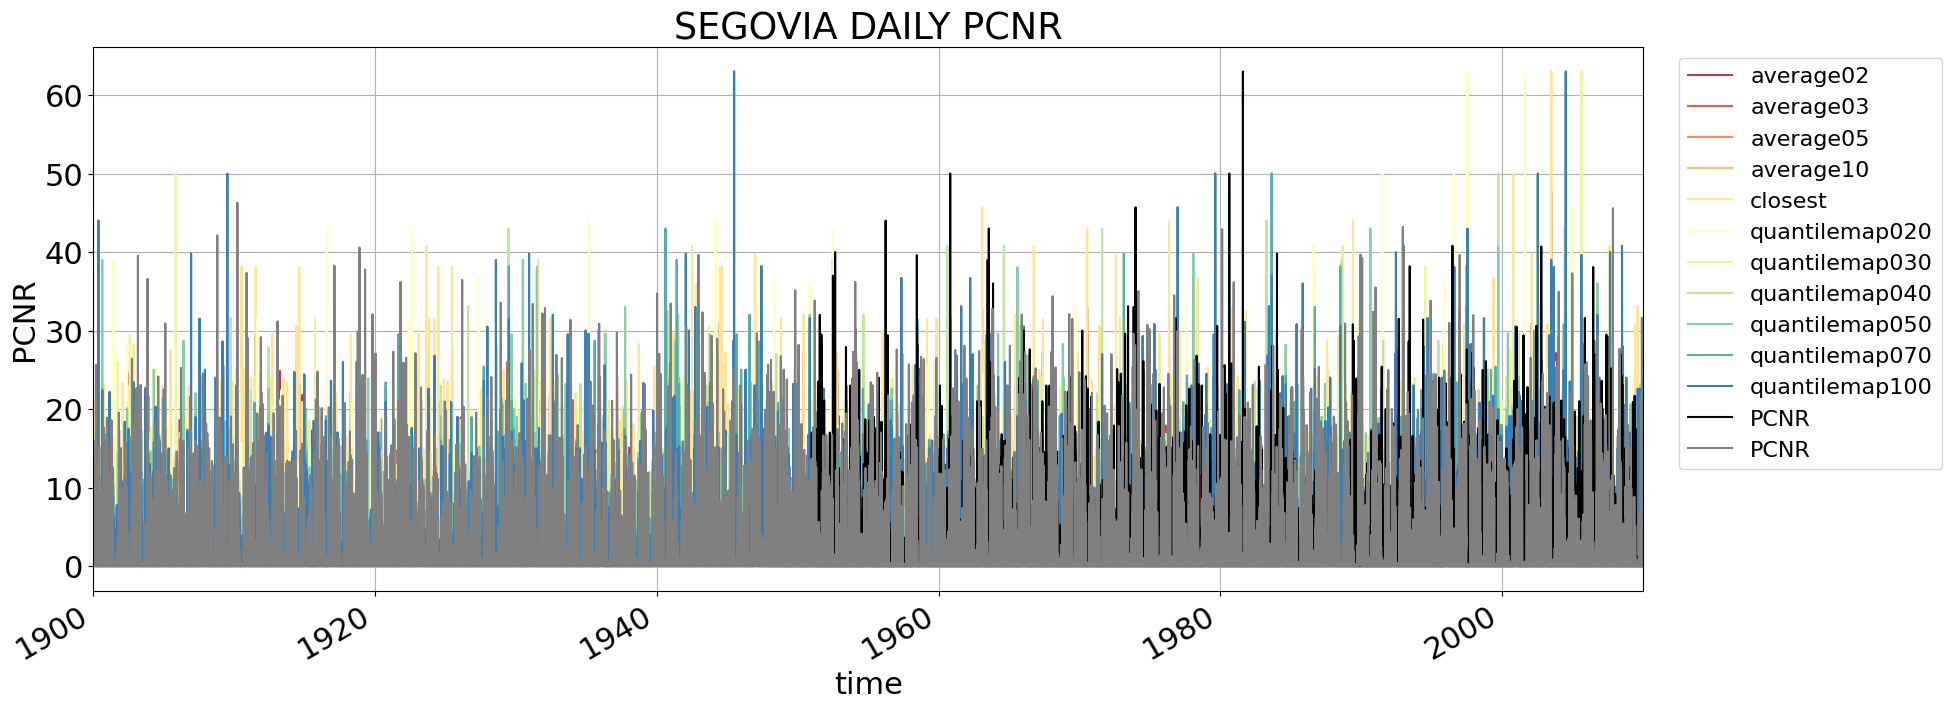

In [9]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=reconstructions_daily, 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="Spectral"
)
station_data_daily[variable_to_validate].plot(ax=ax, color="black")
reanalysis_data_daily[variable_to_validate].plot(ax=ax, color="grey")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)
ax.set_xlim(years[0], years[-1])
ax.set_title(station.name.upper() + " DAILY " + variable_to_validate)
ax.grid()
plt.show()

In [10]:
station_data_daily 

,PCNR
time,
1948-01-01,0.0
1948-01-02,0.0
1948-01-03,0.0
1948-01-04,0.0
1948-01-05,0.0
...,...
2023-07-27,0.2
2023-07-28,0.0
2023-07-29,0.0


In [11]:
daily_ensemble = rascal.skill_evaluation.ensemble_to_dict(reconstructions_daily)
daily_ensemble["reanalysis"] = reanalysis_data_daily

station_daily_std, daily_skill = rascal.skill_evaluation.get_skill(
    observation=station_data_daily, 
    simulations=daily_ensemble,
    variable=variable_to_validate
)



In [12]:
daily_skill

,bias,rmse,r2,std
average02,0.011545,3.94289,0.165677,2.651575
average03,0.010758,3.735532,0.190916,2.343749
average05,0.01083,3.555047,0.219405,2.0445
average10,0.01517,3.393301,0.257477,1.741748
closest,0.00126,4.513217,0.129496,3.426408
quantilemap020,-0.171605,4.292627,0.220169,3.359903
quantilemap030,-0.138929,4.188701,0.238968,3.262664
quantilemap040,-0.127639,4.172782,0.246113,3.268159
quantilemap050,-0.104111,4.153996,0.245243,3.232661
quantilemap070,-0.078293,4.13367,0.246547,3.183185


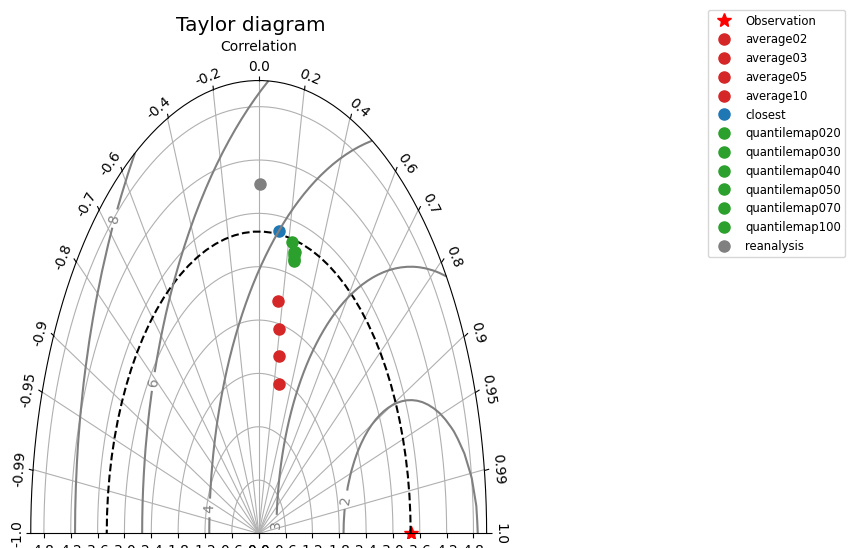

In [13]:
dia = rascal.skill_evaluation.taylor_test(station_daily_std, daily_skill)

### Monthly Series

In [14]:
reconstructions_monthly = rascal.skill_evaluation.get_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1m',
    grouping=groupings[variable_to_validate]
)
if groupings[variable_to_validate] == "mean":
    station_data_monthly = station_data.resample('1m').mean()
    reanalysis_data_monthly = reanalysis_data.resample('1m').mean()
elif groupings[variable_to_validate] == "sum" or groupings[variable_to_validate] == "hydrosum" :
    station_data_monthly = station_data.resample('1m').sum()
    reanalysis_data_monthly = reanalysis_data.resample('1m').sum()

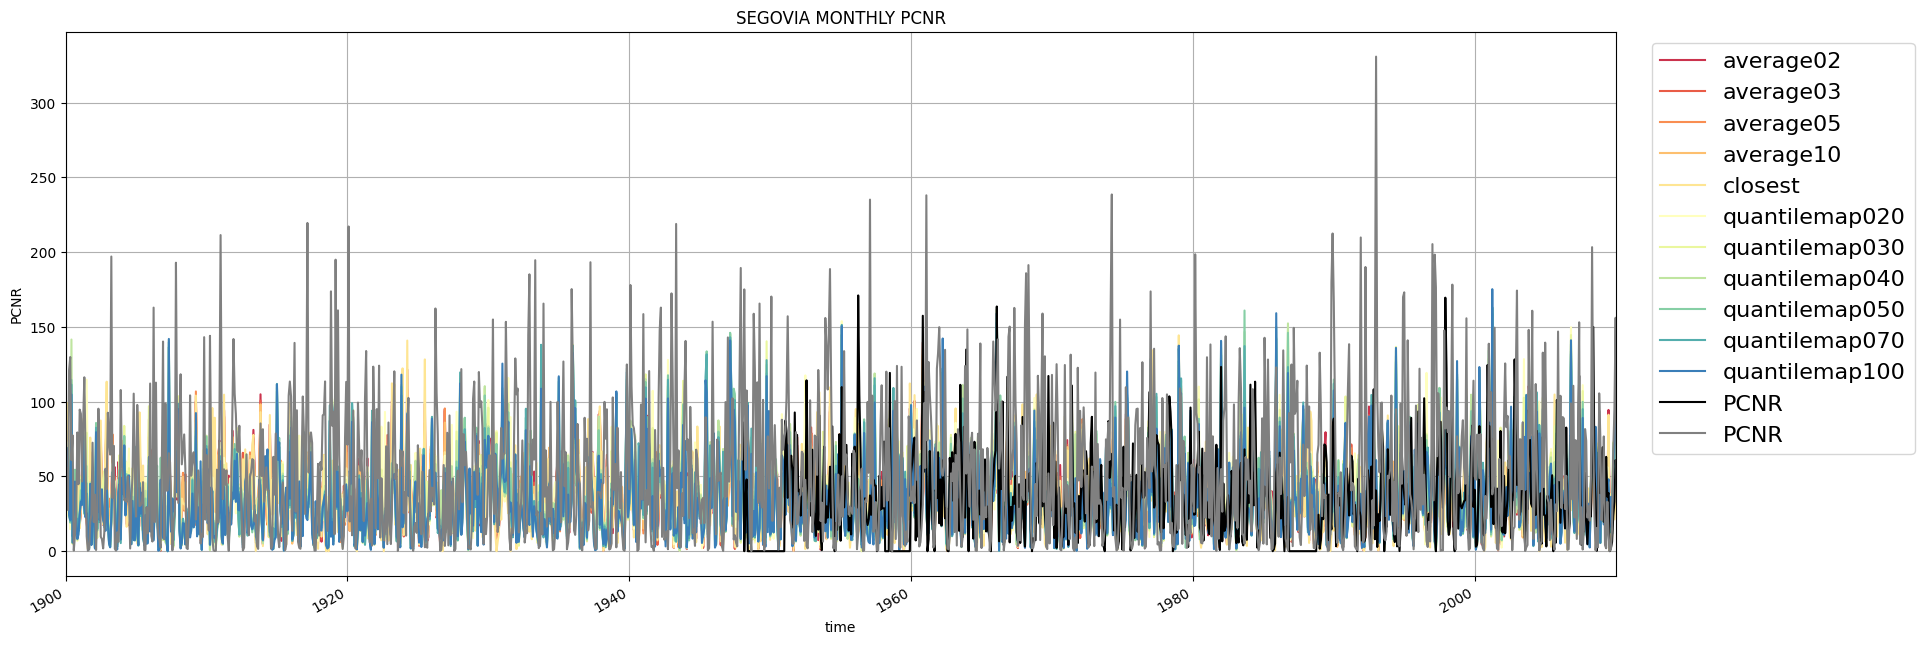

In [15]:
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=reconstructions_monthly, 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="Spectral"
)
station_data_monthly[variable_to_validate].plot(ax=ax, color="black")
reanalysis_data_monthly[variable_to_validate].plot(ax=ax, color="grey")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)
ax.set_xlim(years[0], years[-1])
ax.set_title(station.name.upper() + " MONTHLY " + variable_to_validate)
ax.grid()
plt.show()

In [16]:
monthly_ensemble = rascal.skill_evaluation.ensemble_to_dict(reconstructions_monthly)
monthly_ensemble["reanalysis"] = reanalysis_data_monthly

station_monthly_std, monthly_skill = rascal.skill_evaluation.get_skill(
    observation=station_data_monthly, 
    simulations=monthly_ensemble,
    variable=variable_to_validate
)


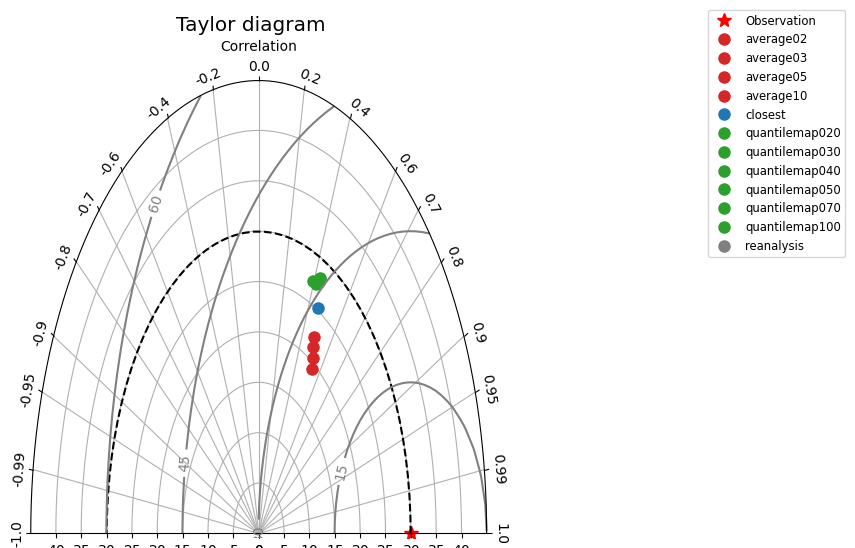

In [17]:
rascal.skill_evaluation.taylor_test(station_monthly_std, monthly_skill)

### Yearly Series

In [18]:
reconstructions_yearly = rascal.skill_evaluation.get_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1Y',
    grouping=groupings[variable_to_validate]
)
if groupings[variable_to_validate] == "mean":
    
    station_data_yearly = station_data.resample('1Y').mean()
    reanalysis_data_yearly = reanalysis_data.resample('1Y').mean()
    
elif groupings[variable_to_validate] == "sum":
    
    station_data_yearly = station_data.resample('1Y').sum()
    reanalysis_data_yearly = reanalysis_data.resample('1Y').sum()
    
elif groupings[variable_to_validate] == "hydrosum":
    
    station_data_yearly = rascal.skill_evaluation.get_hydrological_years(station_data)
    station_data_yearly = station_data_yearly.groupby("hydroyear").sum()
    station_data_yearly.index.name = "time"
    
    reanalysis_data_yearly = rascal.skill_evaluation.get_hydrological_years(reanalysis_data)
    reanalysis_data_yearly = reanalysis_data_yearly.groupby("hydroyear").sum()
    reanalysis_data_yearly.index.name = "time"

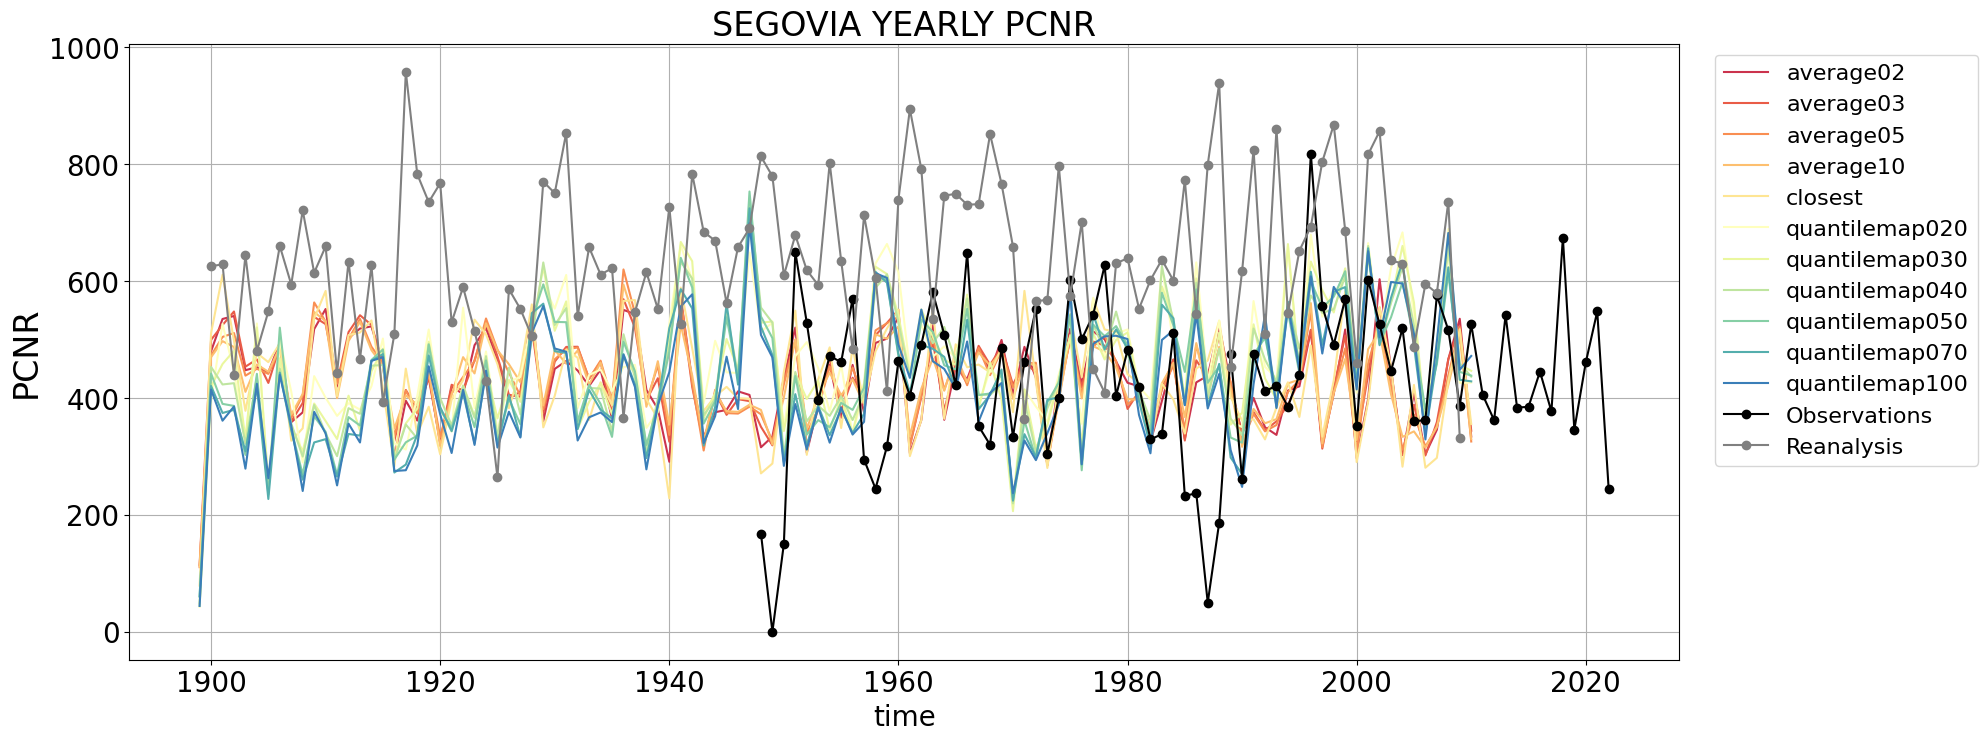

In [19]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=reconstructions_yearly[1:], 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="Spectral"
)
station_data_yearly[variable_to_validate][1:-1].plot(ax=ax, color="black", label="Observations", marker="o")
reanalysis_data_yearly[variable_to_validate][1:-1].plot(ax=ax, color="grey", label="Reanalysis", marker="o")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)

ax.set_ylabel(variable_to_validate, fontsize=24)
# ax.set_xlim(years[0], years[-1])
ax.set_title(station.name.upper() + " YEARLY " + variable_to_validate)
ax.grid()

plt.show()

In [20]:
yearly_ensemble = rascal.skill_evaluation.ensemble_to_dict(reconstructions_yearly)
yearly_ensemble["reanalysis"] = reanalysis_data_yearly

station_yearly_std, yearly_skill = rascal.skill_evaluation.get_skill(
    observation=station_data_yearly, 
    simulations=yearly_ensemble,
    variable=variable_to_validate
)


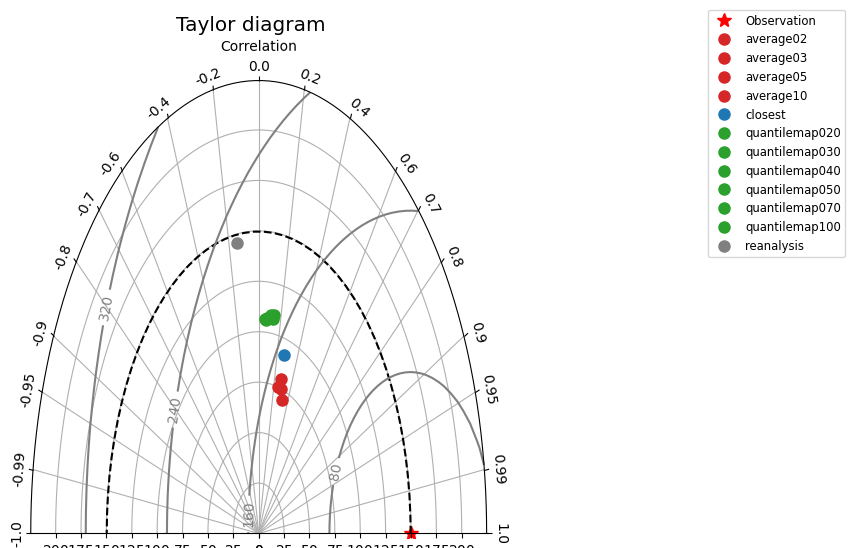

In [21]:
rascal.skill_evaluation.taylor_test(station_yearly_std, yearly_skill)

In [22]:
station_data = station_data.drop(columns=["hydroyear"])

In [23]:
methods = sorted(list(set(reconstructions_yearly["similarity_method"].values)))
    

In [24]:
error_yearly = []
for method in methods:
    
    method_condition = (reconstructions_yearly["similarity_method"] == method)
    
    # Get individual reconstructions
    reconstruction = reconstructions_yearly.loc[method_condition]
    reconstruction = reconstruction.set_index("time")[variable_to_validate].to_frame()
    error = (reconstruction - station_data_yearly)
    
    error["similarity_method"] = method
    
    error = error.reset_index()
    error_yearly.append(error)

error_yearly = pd.concat(error_yearly, axis=0)
error_yearly = error_yearly.dropna()
error_yearly = error_yearly.reset_index()


error_reanalysis = reanalysis_data_yearly - station_data_yearly

In [25]:
reanalysis_data_yearly


,PCNR,observation
time,,
1899,218.992706,NaN
1900,625.684326,NaN
1901,628.761597,NaN
1902,438.874969,NaN
1903,644.579651,NaN
...,...,...
2006,595.402832,362.4
2007,579.309631,575.5
2008,736.359741,516.3


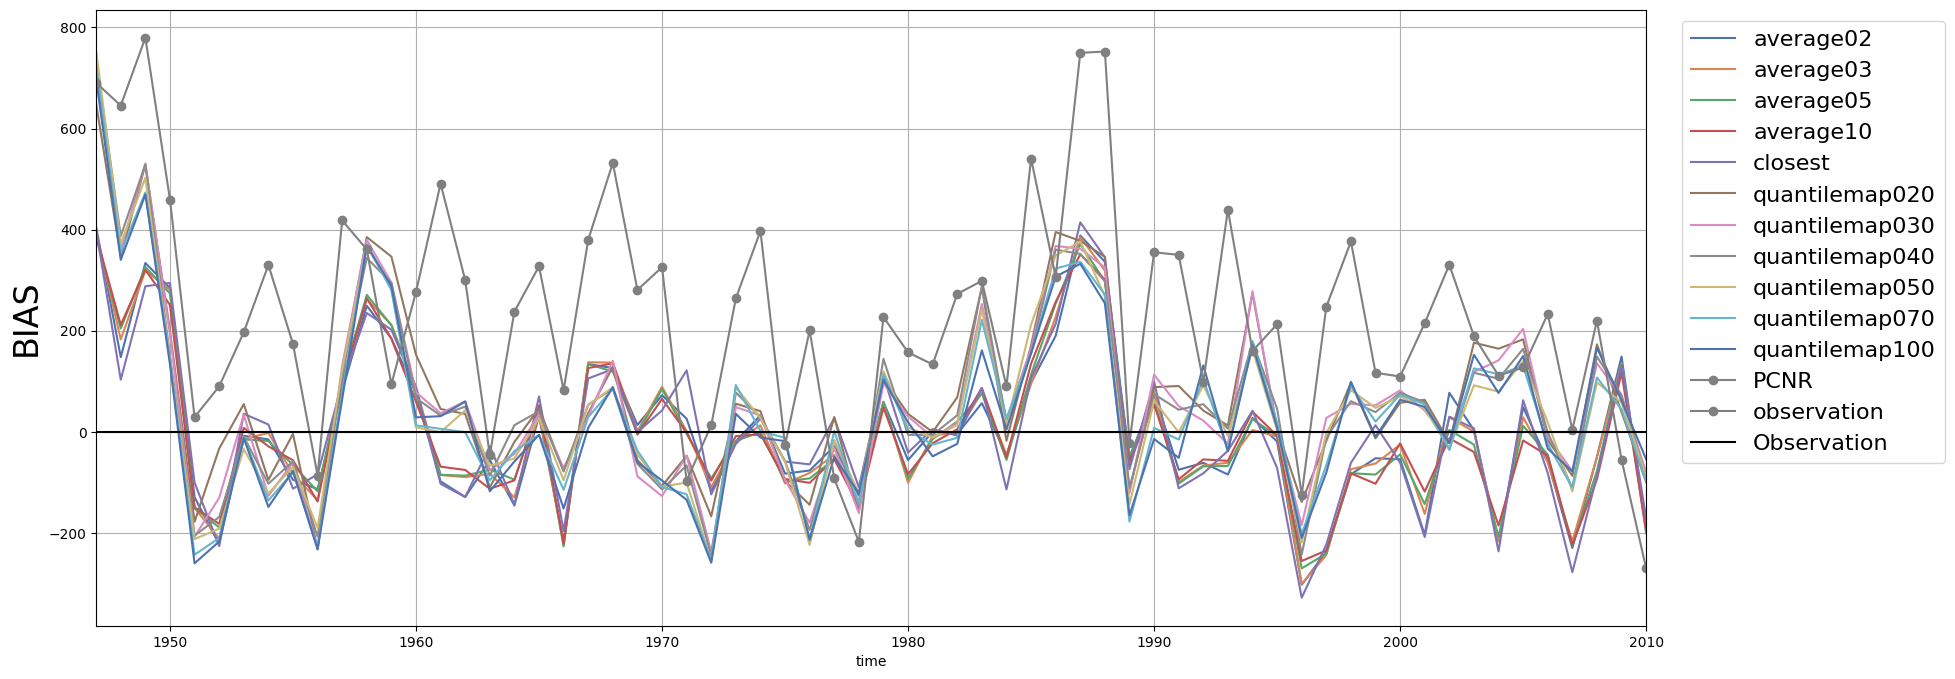

In [26]:
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=error_yearly, 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="deep"
)
error_reanalysis.plot(color="grey", ax=ax, label="Reanalysis", marker='o')
ax.axhline(0, color="black", label="Observation")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)
ax.set_ylabel("BIAS", fontsize=24)
ax.set_xlim(error_yearly["time"].values[0], error_yearly["time"].values[-1])

ax.grid()

### Seasonality

[Text(1, 0, 'J'),
 Text(2, 0, 'F'),
 Text(3, 0, 'M'),
 Text(4, 0, 'A'),
 Text(5, 0, 'M'),
 Text(6, 0, 'J'),
 Text(7, 0, 'J'),
 Text(8, 0, 'A'),
 Text(9, 0, 'S'),
 Text(10, 0, 'O'),
 Text(11, 0, 'N'),
 Text(12, 0, 'D')]

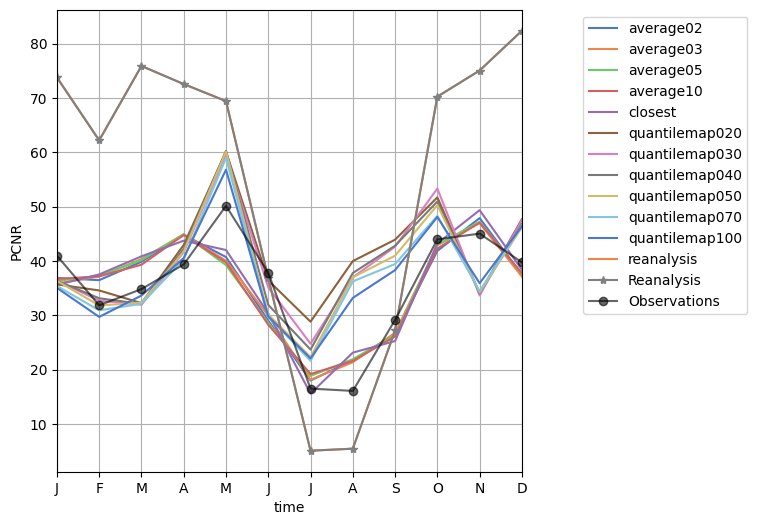

In [27]:
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(6,6))
ax = fig.subplots()

seasonality = pd.DataFrame()

for model, reconstruction in daily_ensemble.items():
    
    reconstruction, observations = rascal.skill_evaluation.get_common_data(reconstruction, station_data_daily)
    reanalysis_data_i, observations = rascal.skill_evaluation.get_common_data(reanalysis_data_daily["PCNR"].to_frame(), station_data_daily)

    if variable_to_validate == "PCNR":
        reconstruction_monthly = reconstruction.resample('1m').sum()
        observation_monthly = observations.resample('1m').sum()
        reanalysis_monthly = reanalysis_data_i.resample('1m').sum()

        reconstruction_monthly = reconstruction_monthly.groupby(reconstruction_monthly.index.month).mean() 
        observation_monthly = observation_monthly.groupby(observation_monthly.index.month).mean() 
        reanalysis_monthly = reanalysis_monthly.groupby(reanalysis_monthly.index.month).mean() 
        
    else:
        reconstruction_monthly = reconstruction.groupby(reconstruction.index.month).mean() 
        observation_monthly = observations.groupby(observations.index.month).mean()
        reanalysis_monthly = reanalysis_data_i.groupby(reanalysis_data_i.index.month).mean() 
    
    if "closest" in model:
        color = "tab:blue"
    elif "average" in model:
        color = "tab:red"
    elif "quantilemap" in model:
        color = "tab:green"
    else:
        color = "grey"
    
    reconstruction_monthly["method"] = model
    reconstruction_monthly.index.name = "month"

    seasonality = pd.concat([seasonality, reconstruction_monthly])


seasonality = seasonality.reset_index()  

sns.lineplot(ax=ax, data=seasonality, x="month", y=variable_to_validate, hue="method", palette="muted")
reanalysis_monthly.columns = ["Reanalysis"]
reanalysis_monthly.plot(ax=ax, color="grey", marker='*')
observation_monthly.columns = ["Observations"]
observation_monthly.plot(ax=ax, label="Observations", color="black", marker='o', alpha=0.6)
ax.legend(loc="upper right", bbox_to_anchor=[1.5, 1], ncol=1)
ax.set_xticks(range(1, 13))
ax.set_xlim(1,12)
ax.grid()
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])


### Distributions

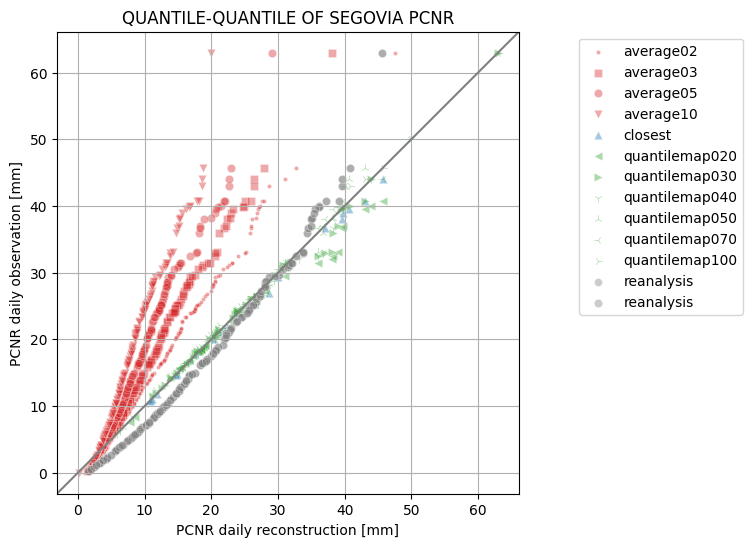

In [44]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()

for i, (model, reconstruction) in enumerate(daily_ensemble.items()):
    
    quantiles = rascal.skill_evaluation.quantile_plots(
        predicted=reconstruction, 
        observed=station_data_daily
    )

    if "closest" in model:
        color = "tab:blue"
    elif "average" in model:
        color = "tab:red"
    elif "quantilemap" in model:
        color = "tab:green"
    else:
        color = "grey"
        
    sns.scatterplot(
        data=quantiles, 
        x='Reconstruction', 
        y='Observation', 
        ax=ax, 
        alpha=0.4,
        color=color,
        label=model,
        marker=list(Line2D.markers.keys())[i]
    )
        
reanalysis_quantiles = rascal.skill_evaluation.quantile_plots(
        predicted=reanalysis_data_daily, 
        observed=station_data_daily
    )

sns.scatterplot(
        data=reanalysis_quantiles, 
        x='Reconstruction', 
        y='Observation', 
        ax=ax, 
        alpha=0.4,
        color="grey",
        label="reanalysis"
)
ax.axline([0, 0], [1, 1], color='grey')
ax.set_aspect('equal')
ax.grid()
ax.set_title("QUANTILE-QUANTILE OF " + station.name.upper() + " " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " daily observation " + units[variable_to_validate])
ax.set_xlabel(variable_to_validate + " daily reconstruction " + units[variable_to_validate])
ax.legend(loc="upper right", bbox_to_anchor=[1.5, 1], ncol=int(np.ceil(len(daily_ensemble)/20)))